In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
df = pd.read_csv('../../bars/bitmex-XBTUSD-1min.csv', parse_dates=['time'])
df.sort_values('time', ignore_index=True, inplace=True)
df.drop_duplicates(subset='time', ignore_index=True, inplace=True)

Для начала надо посмотреть, если ли разрывы в данных, для временных рядов это критично

In [3]:
time_diff = (df.time - df.time.shift(1)).dt.total_seconds()
time_diff.value_counts()

60.0      567103
120.0        730
180.0         23
240.0          2
300.0          1
1860.0         1
1260.0         1
780.0          1
4860.0         1
480.0          1
Name: time, dtype: int64

In [4]:
idx_warn = time_diff[time_diff >= 181].index
for i in idx_warn:
    row = df.iloc[i - 1]
    print(i, row.time, 'missing', int(time_diff.iloc[i] / 60), 'min')

96921 2021-03-09 07:21:00 missing 5 min
139802 2021-04-08 02:14:00 missing 31 min
190055 2021-05-13 00:23:00 missing 21 min
190058 2021-05-13 00:46:00 missing 13 min
320889 2021-08-12 02:14:00 missing 81 min
437697 2021-11-01 09:20:00 missing 8 min
566701 2022-01-30 04:20:00 missing 4 min
566827 2022-01-30 06:31:00 missing 4 min


Частично даты пропусков совпадает со сбоями, отмеченными на сайте [bitmex](https://status.bitmex.com/uptime), но часть нет. необходимо посомтреть, насколько критичными были отклонения цены после пропуска

In [5]:
idx_warn = time_diff[time_diff >= 61].index
for i in idx_warn:
    row = df.iloc[i - 1]
    price_change = np.round(100 * abs(row.close - df.open.iloc[i]) / row.close, 4)
    if (price_change > 0.05):
        print(i, row.time, 'missing', int(time_diff.iloc[i] / 60), 'min -> price changed ', price_change, '%')

276417 2021-07-12 02:03:00 missing 2 min -> price changed  0.0513 %


Как видно, несмотря на иногда значительные пропуски по времени, по цене значительных пропусков нет. Самый дольшой пропуск едва превышает 5 сотых процента, что для такого волатильного актива, как криптовалюта, пренебрежимо мало

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567865 entries, 0 to 567864
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        567865 non-null  datetime64[ns]
 1   open        567865 non-null  float64       
 2   high        567865 non-null  float64       
 3   low         567865 non-null  float64       
 4   close       567865 non-null  float64       
 5   avg         567865 non-null  float64       
 6   wavg        567865 non-null  float64       
 7   median      567865 non-null  float64       
 8   sum_vol     567865 non-null  int64         
 9   up_sum_vol  567865 non-null  int64         
 10  md_sum_vol  567865 non-null  int64         
 11  lo_sum_vol  567865 non-null  int64         
 12  net_vol     567865 non-null  int64         
 13  up_net_vol  567865 non-null  int64         
 14  md_net_vol  567865 non-null  int64         
 15  lo_net_vol  567865 non-null  int64         
 16  cn

In [8]:
df.sample(5)

,time,open,high,low,close,avg,wavg,median,sum_vol,up_sum_vol,md_sum_vol,lo_sum_vol,net_vol,up_net_vol,md_net_vol,lo_net_vol,cnt,hbl
368313,2021-09-14 03:28:00,45095.5,45106.5,45095.5,45106.5,45105.7,45105.0,45106.5,287000,0,287000,0,-177000,0,-177000,0,43,False
447378,2021-11-08 03:36:00,65150.0,65150.5,65150.0,65150.5,65150.0,65150.0,65150.0,136700,0,136700,0,-136100,0,-136100,0,26,False
555363,2022-01-22 07:11:00,35827.5,35827.5,35772.0,35800.0,35790.5,35787.7,35793.5,210800,0,35200,175600,40600,0,-9600,50200,67,True
344272,2021-08-28 10:14:00,48982.5,48990.0,48982.5,48990.0,48984.8,48984.0,48983.0,32000,0,32000,0,31600,0,31600,0,35,False
304456,2021-07-31 15:56:00,41518.5,41538.0,41518.5,41537.5,41524.0,41526.6,41518.5,286600,51000,235600,0,148200,51000,97200,0,29,False


Пропусков в самих данных также нет. 
Имеем дело со следующими столбцами:

| наименование | тип | описание |
|--------------|-------|--------|
|`time`        | datetime   | время начала периода (бара) |
|`open`        | float      | цена первой сделки периода   |    
|`high`        | float      | максимальная цена сделки периода |
|`low`         | float      | минимальная цена сделки периода   |    
|`close`       | float      | цена последней сделки периода |
|`avg`         | float      | средняя цена сделок периода |
|`wavg`        | float      | средневзвешенная по объему цена сделок периода |
|`median`      | float      | медиана цен сделок периода |
|`sum_vol`     | float      | сумма объемов сделок периода |
|`up_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `high` до `max(open, close)`      |
|`md_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `open` до `close`         |
|`lo_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `low` до `min(open, close)` |
|`net_vol`     | float      | нетто-объем сделок периода (сумма объемов покупок минус сумма объемов продаж) |
|`up_net_vol`  | float      | нетто-объемо сделок в промежутке цен от `high` до `max(open, close)`        |
|`md_net_vol`  | float      | нетто-объем сделок в промежутке цен от `open` до `close`     |
|`lo_net_vol`  | float      | нетто-объемо сделок в промежутке цен от `low` до `min(open, close)`   |      
|`cnt`         | int        | количество сделок за период|
|`hbl`         | boolean    | цена `high` была достигнута раньше, чем цена `low`, 

<AxesSubplot:>

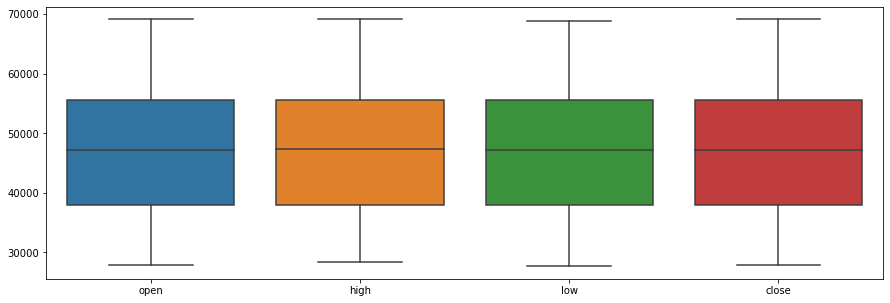

In [9]:
sns.boxplot(data=df[['open', 'high', 'low', 'close']])

По ценам выбросов нет. Поисследуем ряд цен внимательнее:

<AxesSubplot:xlabel='close', ylabel='Count'>

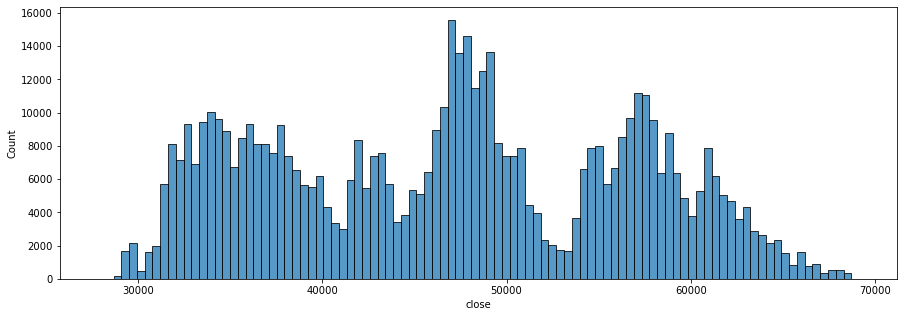

In [10]:
sns.histplot(df.close)

О нормальности или равномерности распределения промолчим...

<AxesSubplot:title={'center':'StDev (Close)'}, xlabel='time', ylabel='close'>

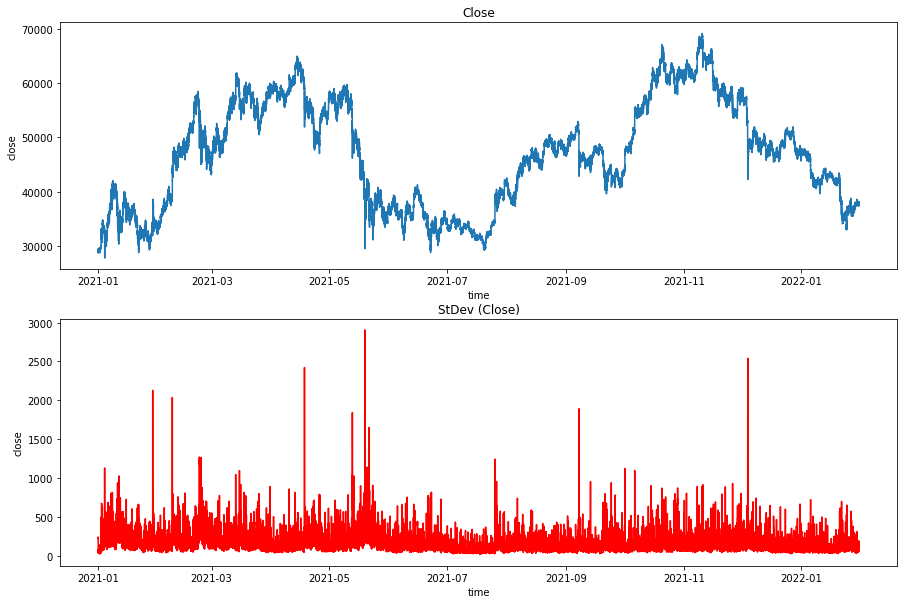

In [20]:
sig = df.close.rolling(100).std()
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].set_title('Close')
ax[1].set_title('StDev (Close)')
sns.lineplot(ax=ax[0], y=df.close, x=df.time)
sns.lineplot(ax=ax[1], y=sig, x = df.time, color='r')

Налицо *гетероскедастичность* - дисперсия значений ряда меняется во времени. Можно проверить это утверждение более строго, проведя, например, [тест Уайта](https://en.wikipedia.org/wiki/White_test), но считаю это лишним, т.к. гетероскедастичность ценовых рядов давно доказана и принята нормой по умолчанию. 

Рассмотрим ряд автокорреляций цены: 

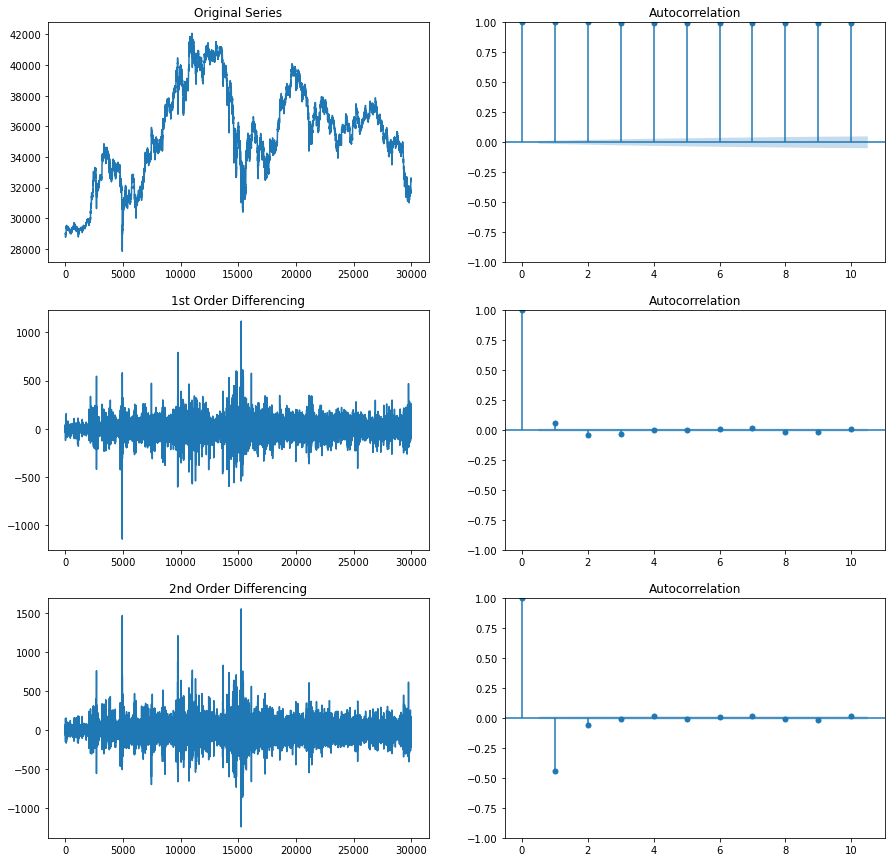

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

val = df.close[:30000]

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(15,15))
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1], lags=10)

# 1st Differencing
axes[1, 0].plot(val.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(val.diff().dropna(), ax=axes[1, 1], lags=10)

# 2nd Differencing
axes[2, 0].plot(val.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(val.diff().diff().dropna(), ax=axes[2, 1], lags=10)

plt.show()

Как видно из правого столбца графиков, ряд сам по себе не является стационарным, т.к. АК лагов статистически значима для многих лагов больших 0

Ряд является интегрированным порядка 1, что видно из правого графика во второй строке, т.е. на нем значимой является только АК лага 0.

Значит, для дальнейшей работы (по крайней мере для той ее части, где используются модели финансовой математики) целесообразно использовать или первые приращения ценового ряда или использовать модели, которые учитывают интегрированность, например, `ARIMA`

Посмотрим на распределение объемов. Возьмем только столбец `sum_vol`, т.к. остальные - это в некоторой степени его производные.

<AxesSubplot:title={'center':'ln(sum_vol)'}, xlabel='sum_vol', ylabel='Count'>

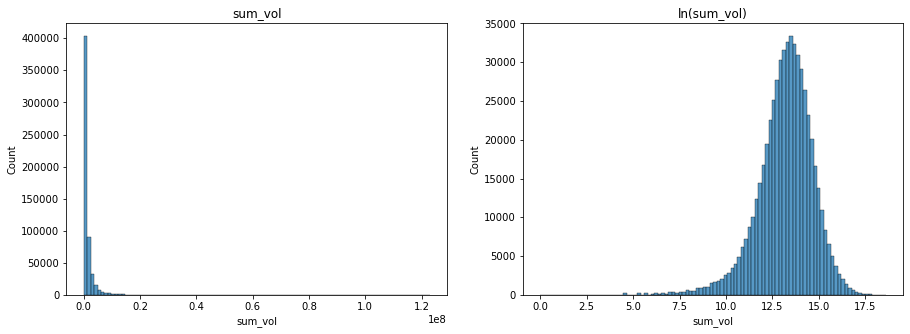

In [19]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title('sum_vol')
sns.histplot(df.sum_vol, bins=100, ax=ax[0])
ax[1].set_title('ln(sum_vol)')
sns.histplot(np.log(df.sum_vol), bins=100, ax=ax[1])

Распределение похоже на экспоненциальное, что вполне зарактерно для объемов торгов финансовых активов. Проблем не диагностировано.